In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
from matplotlib.pylab import permutation
from matplotlib.pylab import concatenate
from matplotlib.pylab import rand
from matplotlib.pylab import randn
%config InlineBackend.figure_format = 'retina'
import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
matplotlib.rcParams['figure.figsize'] = (9.7082039325, 6.0)
matplotlib.rcParams['xtick.labelsize'] = 18.0
matplotlib.rcParams['ytick.labelsize'] = 18.0
matplotlib.rcParams['axes.labelsize'] = 20.0
matplotlib.rcParams['legend.fontsize'] = 18.0
matplotlib.rcParams['font.family']= 'serif'
matplotlib.rcParams['font.sans-serif']= ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex']= False 
matplotlib.rcParams['mathtext.fontset']= 'stixsans'

#sns.set(rc={'figure.figsize':(11.7,8.27)})

from scipy.optimize import fsolve
import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)

import lal
from scipy.stats import multivariate_normal
from tqdm import tqdm_notebook, tqdm

import warnings

In [2]:
G = lal.G_SI
c = lal.C_SI
Msun = lal.MSUN_SI
year = 3600.*24.*365
Msins=Msun*G/c/c/c #solar mass in seconds

In [3]:
def m1_m2_to_mchirp_eta(m1,m2):
    Mchirp = np.power(m1*m2,3./5)*np.power(m1+m2,-1./5)
    eta=(m2*m1)/(m1+m2)/(m1+m2)
    return Mchirp,eta

def mchirp_q_to_m1_m2(mchirp,q):
    factor = mchirp*np.power(1+q, 1.0/5.0)
    m1 = factor*np.power(q, -3.0/5.0)
    m2 = factor*np.power(q, 2.0/5.0)
    return m1,m2

def fdot0PN(f0,m1,m2):
    Mc,eta=m1_m2_to_mchirp_eta(m1,m2)
    
    x=np.pi*Mc*f0
    
    return 96./5/np.pi/Mc/Mc*np.power(x,11./3)

def fdot1PN(f0,m1,m2):
    Mc,eta=m1_m2_to_mchirp_eta(m1,m2)
    
    x=np.pi*Mc*f0
    
    return -2./35/np.pi/Mc/Mc*np.power(eta,-2./5)*(743+924*eta)*np.power(x,13./3)

def fdot1p5PN(f0,m1,m2):
    Mc,eta=m1_m2_to_mchirp_eta(m1,m2)
    
    x=np.pi*Mc*f0
    
    ## let's assume maximal spins. we find below that even in this case this term doesn't matter
    chi1=1
    chi2=1
    eta=(m1*m2)/(m1+m2)/(m1+m2)
    chieff=(m1*chi1+m2*chi2)/(m1+m2)
    chia=(chi1-chi2)/2
    delta=(m1-m2)/(m1+m2)
    
    beta = 1./3*((113-76*eta)/4.*chieff+76./4*delta*eta*chia)
    
    return -96./5/np.pi/Mc/Mc*np.power(eta,-3./5)*(beta-4*np.pi)*np.power(x,14./3)
    
def fddot0PN(f0,m1,m2):
    Mc,eta=m1_m2_to_mchirp_eta(m1,m2)
    
    x=np.pi*Mc*f0
    
    return 33792./25/np.pi/Mc/Mc/Mc*np.power(x,19./3)

def PsiFull(t,f0,m1,m2):
    Psi0=2*np.pi*f0*t
    Psidot=np.pi*(fdot0PN(f0,m1,m2)+fdot1PN(f0,m1,m2))*t*t
    Psiddot=0.5*np.pi*fddot0PN(f0,m1,m2)*t*t*t
    
    return Psi0+Psidot+Psiddot

def Psi0PN(t,f0,m1,m2):
    Psi0=2*np.pi*f0*t
    Psidot=np.pi*(fdot0PN(f0,m1,m2))*t*t
    Psiddot=0.5*np.pi*fddot0PN(f0,m1,m2)*t*t*t
    
    return Psi0+Psidot+Psiddot

In [4]:
t=np.arange(0,10*year,1000) #time in seconds

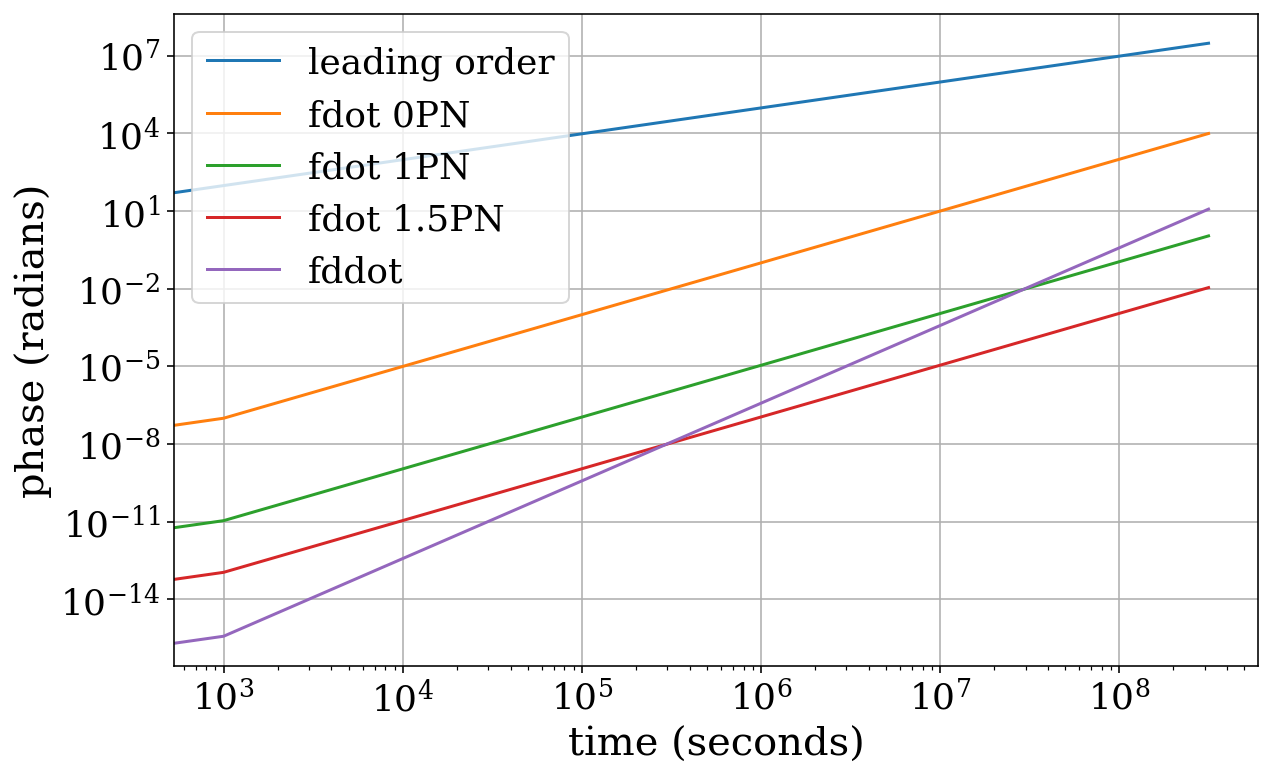

In [7]:
m1=0.5*Msins
m2=0.5*Msins
f0=0.015248
plt.plot(t,abs(2*np.pi*f0*t),label='leading order')
plt.plot(t,abs(np.pi*(fdot0PN(f0,m1,m2))*t*t),label='fdot 0PN')
plt.plot(t,abs(np.pi*(fdot1PN(f0,m1,m2))*t*t),label='fdot 1PN')
plt.plot(t,abs(np.pi*(fdot1p5PN(f0,m1,m2))*t*t),label='fdot 1.5PN')
plt.plot(t,abs(0.5*np.pi*fddot0PN(f0,m1,m2)*t*t*t),label='fddot')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time (seconds)')
plt.ylabel('phase (radians)')
plt.grid()
plt.legend()
plt.show()

In [11]:
def McfromFdot(f0,fdot):
    den=96./5*np.power(np.pi,8./3)*np.power(f0,11./3)
    
    return np.power(fdot/den,3./5)

def McfromFddot(f0,fddot):
    den=33792./25*np.power(np.pi,16./3)*np.power(f0,19./3)
    
    return np.power(fddot/den,3./10)

def func_opt(Mc,f0,fdot,q):
    m1,m2=mchirp_q_to_m1_m2(Mc,q)
    
    return np.abs(fdot-(fdot0PN(f0,m1,m2)+fdot1PN(f0,m1,m2)))
    #return np.abs(fdot-(fdot0PN(f0,m1,m2)))

def McfromFdotFull(f0,fdot,q):
    InitialGuess = McfromFdot(f0,fdot)
    Mcsol = fsolve(func_opt,InitialGuess,args=(f0,fdot,q))[0]## we need to do this numerically
    
    return Mcsol
